# Space Environment Pathways
This Jupyter Notebook will allow users to play around with the scenarios, in order to get to know the laucnh data.

If you would like to use the scen_properties of a pickle file, then this must be located under the first pyssem folder. In the same folder as model.py

In [120]:
import pandas as pd

path = '/Users/indigobrownhall/Code/pyssem/pyssem/utils/launch/data/ref_scen_SEP1.csv' # your path to the scenario csv file
T = pd.read_csv(path)

# Only use if required, you can run the model, it will save a pickle file and then you can use this to get the scenario data. 
# import pickle
# with open('../scenario-properties-baseline.pkl', 'rb') as f:
#     scen_properties = pickle.load(f)

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_90048/2881098126.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  T = pd.read_csv(path)


Show all of the columns available, the data types and an example:

In [3]:
# print each column name, the data type and an example
for col in T.columns:
    print(f"Column: {col}")
    print(f"Data Type: {T[col].dtype}")
    print(f"Example: {T[col].iloc[0]}")
    print()

Column: obj_id
Data Type: int64
Example: 1

Column: phase_desc
Data Type: object
Example: debris/derelict

Column: phase
Data Type: float64
Example: 4.0

Column: par_id
Data Type: float64
Example: nan

Column: operating_agency
Data Type: object
Example: nan

Column: const_name
Data Type: object
Example: nan

Column: const_shell_id
Data Type: float64
Example: nan

Column: mass
Data Type: float64
Example: 1.47

Column: area
Data Type: float64
Example: 0.0214

Column: diam_lcola
Data Type: float64
Example: 0.165068

Column: diam_tumbl
Data Type: float64
Example: 0.131711

Column: diam_char
Data Type: float64
Example: 0.146674

Column: obj_type
Data Type: int64
Example: 2

Column: length
Data Type: float64
Example: nan

Column: width
Data Type: float64
Example: nan

Column: depth
Data Type: float64
Example: nan

Column: active
Data Type: float64
Example: 0.0

Column: maneuverable
Data Type: float64
Example: 0.0

Column: stkp_flg
Data Type: float64
Example: 0.0

Column: stkp_box_r
Data Type

<Axes: >

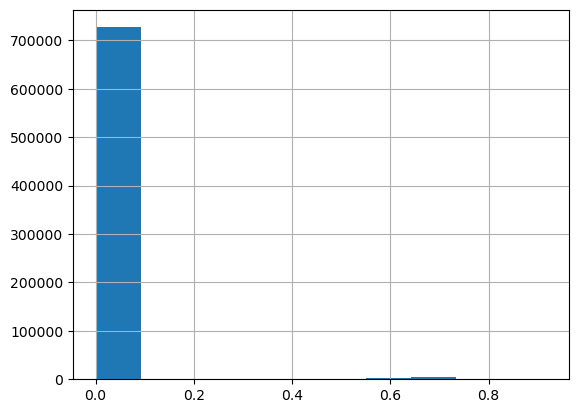

In [4]:
T['ecc'].hist()

### Use this code - as a template -  to be able to explore the data. 

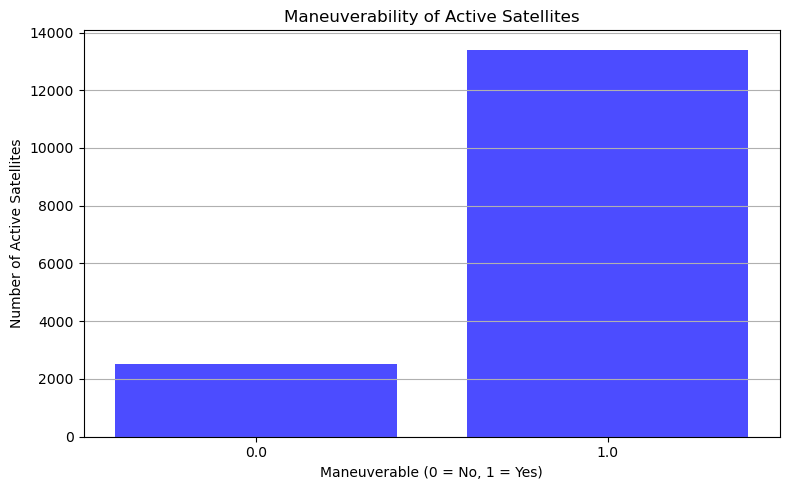

In [43]:
import matplotlib.pyplot as plt

# Filter active satellites
active_satellites = T[T['obj_type'] == 2]

# Get counts of maneuverability values
maneuver_counts = active_satellites['maneuverable'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(maneuver_counts.index.astype(str), maneuver_counts.values, color='blue', alpha=0.7)
plt.xlabel('Maneuverable (0 = No, 1 = Yes)')
plt.ylabel('Number of Active Satellites')
plt.title('Maneuverability of Active Satellites')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [6]:
# plot the number of active satellites before 2025 that don't have a constellation name


8212


In [118]:
# Filter active satellites (object type 2)
active_satellites = T[T['obj_type'] == 2].copy()

# only if date is greater than 2025
active_satellites = active_satellites[active_satellites['year_start'] < 2025]

print(len(active_satellites))
active_satellites['const_name'] = active_satellites['const_name'].fillna('Unassigned')
active_satellites = active_satellites[active_satellites['const_name'] == 'Unassigned']

print(len(active_satellites))


# Replace NaN constellation names with a placeholder

print(len(active_satellites))

# Filter for LEO (semi-major axis < 8371 km)
active_satellites = active_satellites[active_satellites['sma'] < 8371]

print(len(active_satellites))
# Filter for maneuverable satellites
# active_satellites = active_satellites[active_satellites['maneuverable'] == 1]

# Filter for satellites with mass <= 20 kg
# active_satellites = active_satellites[active_satellites['mass'] >= 20]

# Only phase 2 and 3
# active_satellites = active_satellites[active_satellites['phase'].isin([4])]

print(len(active_satellites))


# # Keep only unique parent_id values (first occurrence)
# # active_satellites = active_satellites.drop_duplicates(subset=['par_id'], keep='first')

# print(f"Active satellites in leo with unique parent_id: {len(active_satellites)}")

# # unassigned_satellites = active_satellites[active_satellites['const_name'] == 'Unassigned']

# # Count satellites by constellation name
# const_counts = active_satellites['const_name'].value_counts().sort_index()

# # Plot
# plt.figure(figsize=(10, 6))
# plt.bar(const_counts.index.astype(str), const_counts.values, color='steelblue', alpha=0.8)
# plt.xlabel('Constellation Name')
# plt.ylabel('Number of Active Satellites')
# plt.title('Constellation Membership of Active Satellites (Unique Parent IDs)')
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

11592
4114
4114
4113
4113


In [ ]:
# for each unique id, plot the start of the phase_start for phase 3 and end of phase2 for Su satellites\
# left axis unique id, plot the points in series of time for the start

# year start, end start # year start end start

Now we can check which filters work. 

In [ ]:
# This function has been taken for pyssem and allows you to pass a list of species queries and test it. 

def assign_species_to_population(T, species_mapping):
    """
    Applies a list of pandas query strings to assign species classes to the population.
    
    :param T: pandas.DataFrame representing the population
    :param species_mapping: list of assignment strings (e.g., T.loc[...] = ...)
    :return: updated DataFrame with 'species_class' assigned
    """
    # Initialize the column
    T['species_class'] = "Unknown"

    # Apply each mapping rule via exec
    for rule in species_mapping:
        try:
            exec(rule)
        except Exception as e:
            print(f"Error applying rule: {rule}\n\t{e}")

    # Print summary of resulting species_class assignments
    print("\nSpecies class distribution:")
    # print(T['species_class'].value_counts())

    # Remove all objects that are still unknown
    try:
        
        T = T[T['species_class'] != "Unknown"]
        # print(f"\n{T['species_class'].value_counts()['Unknown']} objects/rows are being removed.")
    except KeyError:
        print("No unknown species classes found.")

    return T

# species_configuration = [
#     "T.loc[(T['obj_type'] == 2) & (T['phase'].isin([2])) & (T['maneuverable'] == 1), 'species_class'] = 'Su'",
#     "T.loc[(T['obj_type'] == 2) & (T['mass'] <= 20) & (T['phase'].isin([2])), 'species_class'] = 'Sns'",
#     "T.loc[(T['obj_type'] == 2) & (T['phase'].isin([2])) & (T['maneuverable'] == 1) & (T['const_name'].notna()), 'species_class'] = 'S'",
#     "T.loc[(T['obj_type'] >= 3) & (T['diam_char'] >= 0.1), 'species_class'] = 'N'",
#     "T.loc[(T['obj_type'] == 1), 'species_class'] = 'B'"
# ]

species_configuration = [
    "T.loc[(T['obj_type'] == 2) & (T['phase'].isin([2])) & (T['maneuverable'] == 1) & (T['const_name'].notna()), 'species_class'] = 'S'",
    "T.loc[(T['obj_type'] >= 3) & (T['diam_char'] >= 0.1), 'species_class'] = 'N'",
    "T.loc[(T['obj_type'] == 1), 'species_class'] = 'B'"
]

# # filter between 200 and 2000
T['apogee'] = T['sma'] * (1 + T['ecc'])
T['perigee'] = T['sma'] * (1 - T['ecc'])
T['alt'] = (T['apogee'] + T['perigee']) / 2 - 6378.1

T = T[T['alt'] <= 2000]
T = T[T['alt'] >= 200]
T = T[T['year_start'] < 2009]
# T = T[T['diam_char'] >= 0.1]

T_new = assign_species_to_population(T, species_configuration)

print(T_new['species_class'].value_counts())



Species class distribution:
species_class
N    5649
B     735
S      38
Name: count, dtype: int64


In [ ]:
# look at su, where orbit_epic is <= 2024, maneuverable non constellation
# look at the objects in phase 2, when is the end - plot to see where they are
# look at where phase 3 is and ending



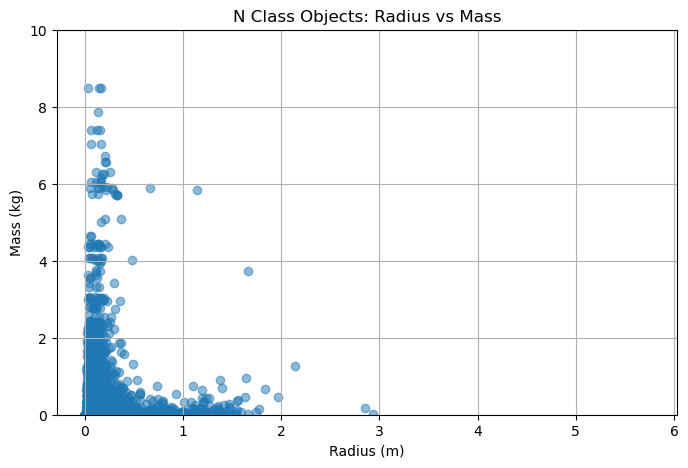

In [9]:
# for N class plot the radius vs mass
N_class = T_new[T_new['species_class'] == 'N']
plt.figure(figsize=(8, 5))
plt.scatter(N_class['diam_char']/2, N_class['mass'], alpha=0.5)
plt.xlabel('Radius (m)')
plt.ylabel('Mass (kg)')
plt.title('N Class Objects: Radius vs Mass')
plt.ylim(0, 10)
plt.grid(True)

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_90048/2634828133.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


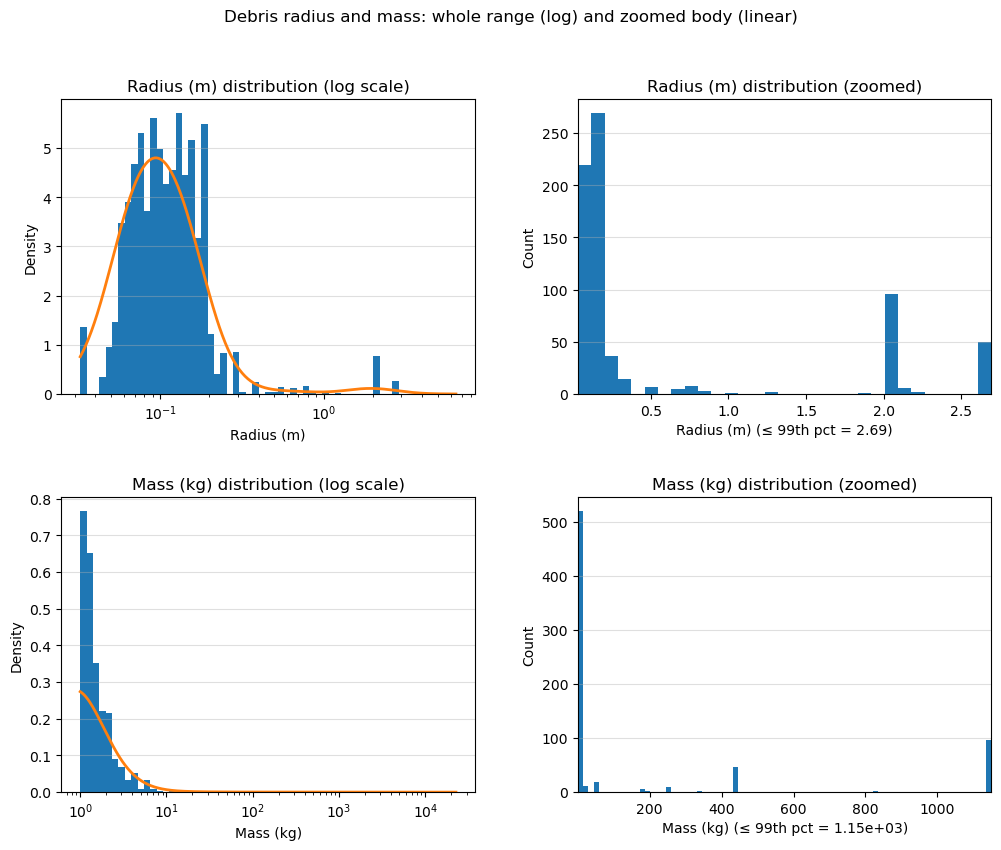

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Optional KDE overlay
try:
    from scipy.stats import gaussian_kde
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

# --- Same filtering as before ---
debris = T[T['obj_type'] >= 3]
debris = debris[debris['mass'] >= 1]

area = debris['area'].astype(float).dropna()
mass = debris['mass'].astype(float).dropna()

# --- Choose how to compute radius from area ---
# If area is circular cross-section (most common), use r = sqrt(area / pi).
USE_CIRCULAR_AREA = True

if USE_CIRCULAR_AREA:
    radius = np.sqrt(area / np.pi)
else:
    # If your dataset's "area" is actually diameter^2, r = sqrt(area)/2
    radius = np.sqrt(area) / 2.0

# Positive-only for log panel; zoom panel uses all finite values
radius = radius[np.isfinite(radius)]
mass   = mass[np.isfinite(mass)]

radius_pos = radius[radius > 0]
mass_pos   = mass[mass > 0]

# Percentile caps for zoomed panels
p99_r = np.quantile(radius, 0.99) if radius.size else np.nan
p99_m = np.quantile(mass,   0.99) if mass.size   else np.nan
radius_zoom = np.clip(radius, None, p99_r) if radius.size else radius
mass_zoom   = np.clip(mass,   None, p99_m) if mass.size   else mass

def fd_edges(x, max_bins=80):
    """Freedman–Diaconis edges with sensible fallbacks."""
    x = np.asarray(x)
    if x.size < 2:
        return np.linspace(np.min(x), np.max(x), 10)
    IQR = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2 * IQR / (x.size ** (1/3)) if IQR > 0 else (np.max(x) - np.min(x)) / 30
    if not np.isfinite(bw) or bw <= 0:
        return np.linspace(np.min(x), np.max(x), 30)
    nbins = min(int(np.ceil((np.max(x) - np.min(x)) / bw)), max_bins)
    nbins = max(nbins, 10)
    return np.linspace(np.min(x), np.max(x), nbins + 1)

def log_hist_with_kde(ax, x, label):
    ax.grid(True, which='both', axis='y', alpha=0.4)
    if x.size == 0:
        ax.text(0.5, 0.5, f'No positive {label.lower()}', ha='center', va='center')
        ax.set_title(f'{label} (log scale)')
        return
    xmin = max(x.min(), np.finfo(float).tiny)
    xmax = x.max()
    bins = np.logspace(np.log10(xmin), np.log10(xmax), 60)
    ax.hist(x, bins=bins, density=True)
    ax.set_xscale('log')
    ax.set_xlabel(label)
    ax.set_ylabel('Density')
    ax.set_title(f'{label} distribution (log scale)')
    if HAS_SCIPY and x.size > 10:
        xs = np.logspace(np.log10(xmin), np.log10(xmax), 400)
        kde = gaussian_kde(np.log10(x))
        pdf_log = kde(np.log10(xs))
        pdf = pdf_log / (xs * np.log(10))  # change-of-variables
        ax.plot(xs, pdf, linewidth=2)

def linear_hist_zoom(ax, x, p99, label):
    if x.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{label} distribution (zoomed)')
        return
    edges = fd_edges(x)
    ax.hist(x, bins=edges)
    ax.set_xlim(edges[0], edges[-1])
    ax.set_xlabel(f'{label} (≤ 99th pct = {p99:.3g})')
    ax.set_ylabel('Count')
    ax.set_title(f'{label} distribution (zoomed)')
    ax.grid(True, axis='y', alpha=0.4)

# --- Figure: 2 rows (Radius, Mass) × 2 cols (Log, Zoom) ---
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 2, wspace=0.25, hspace=0.35)

# Row 1: RADIUS
ax11 = fig.add_subplot(gs[0, 0])
log_hist_with_kde(ax11, radius_pos, 'Radius (m)')  # update unit if different

ax12 = fig.add_subplot(gs[0, 1])
linear_hist_zoom(ax12, radius_zoom, p99_r, 'Radius (m)')

# Row 2: MASS
ax21 = fig.add_subplot(gs[1, 0])
log_hist_with_kde(ax21, mass_pos, 'Mass (kg)')

ax22 = fig.add_subplot(gs[1, 1])
linear_hist_zoom(ax22, mass_zoom, p99_m, 'Mass (kg)')

plt.suptitle('Debris radius and mass: whole range (log) and zoomed body (linear)', y=0.98, fontsize=12)
plt.tight_layout()
plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_90048/3322544244.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


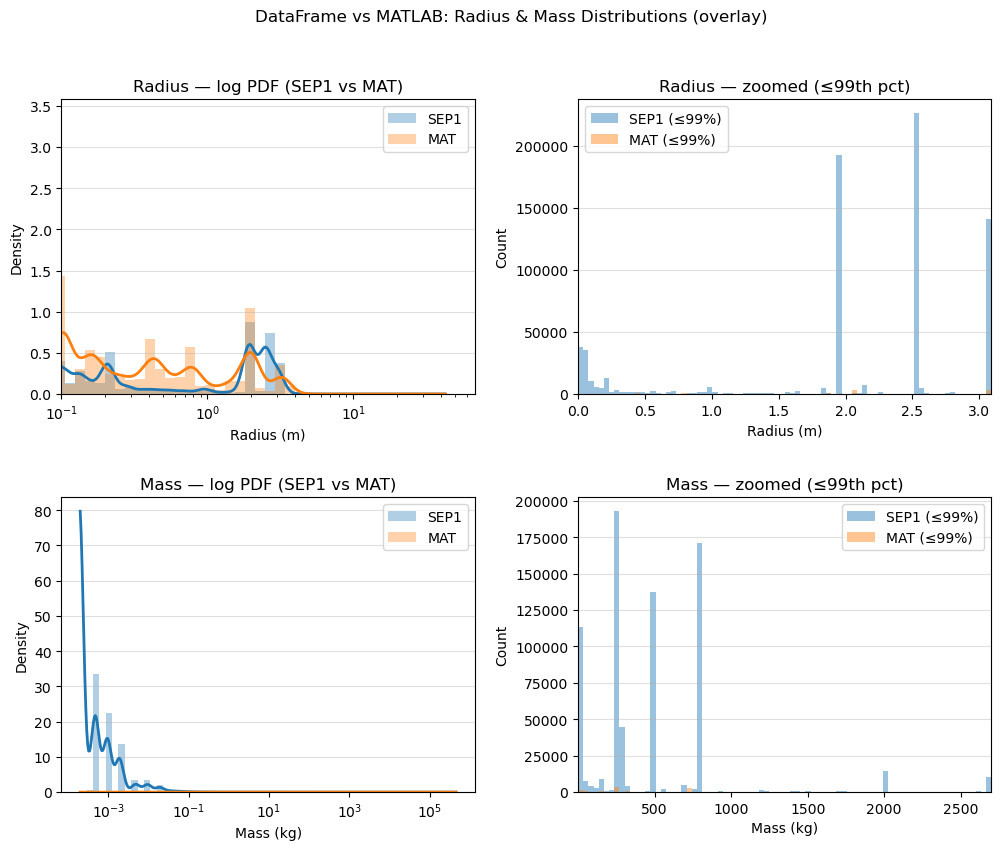

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Optional KDE overlay
try:
    from scipy.stats import gaussian_kde
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

# -------------------------------------------------
# 1) YOUR DATAFRAME (T) → debris subset + radius
# -------------------------------------------------
# Assumes you already have T in memory.
debris_df = T # T[(T['obj_type'] >= 3) & (T['mass'] >= 1)].copy()

# If your 'area' is circular cross-section, radius = sqrt(area / pi).
# If area is actually diameter^2, use sqrt(area)/2 instead.
USE_CIRCULAR_AREA = True
if USE_CIRCULAR_AREA:
    debris_df['radius_from_area'] = np.sqrt(debris_df['area'].astype(float) / np.pi)
else:
    debris_df['radius_from_area'] = np.sqrt(debris_df['area'].astype(float)) / 2.0

mass_df = debris_df['mass'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
rad_df  = debris_df['radius_from_area'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()

# -------------------------------------------------
# 2) MATLAB: load mat_sats_initial_pop (cols 8,9)
# -------------------------------------------------
MAT_PATH = "/Users/indigobrownhall/Code/mocat-VnV-old/supporting_data/initialized_03-2025.mat"
VAR_NAME = "mat_sats"

def load_mat_var(path, varname):
    """Load a variable from a .mat file (supports v7.3 via h5py fallback)."""
    try:
        from scipy.io import loadmat
        md = loadmat(path, squeeze_me=True, struct_as_record=False)
        if varname not in md:
            raise KeyError(f"'{varname}' not in {path}")
        arr = np.asarray(md[varname])
    except NotImplementedError:
        # v7.3 (HDF5) file
        import h5py
        with h5py.File(path, "r") as f:
            # MATLAB stores as column-major; h5py gives Fortran-order
            arr = np.array(f[varname])
    return arr

Xmat = load_mat_var(MAT_PATH, VAR_NAME)

# Ensure 2D with >= 9 columns (MATLAB→Python column fix)
Xmat = np.atleast_2d(np.array(Xmat))
if Xmat.shape[1] < 9 and Xmat.shape[0] >= 9:
    Xmat = Xmat.T
if Xmat.shape[1] < 9:
    raise ValueError(f"{VAR_NAME} does not have ≥9 columns (shape={Xmat.shape}).")

mass_mat = Xmat[:, 7].astype(float)  # MATLAB col 8 → Python index 7
rad_mat  = Xmat[:, 8].astype(float)  # MATLAB col 9 → Python index 8

# Match your filtering: mass >= 1, finite only
mask = np.isfinite(mass_mat) & np.isfinite(rad_mat) & (mass_mat >= 1)
mass_mat = mass_mat[mask]
rad_mat  = rad_mat[mask]



# -------------------------------------------------
# 3) Plot helpers
# -------------------------------------------------
def fd_edges(x, max_bins=80):
    """Freedman–Diaconis histogram edges with fallbacks."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return np.linspace(np.min(x), np.max(x), 10)
    IQR = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2 * IQR / (x.size ** (1/3)) if IQR > 0 else (np.max(x) - np.min(x)) / 30
    if not np.isfinite(bw) or bw <= 0:
        return np.linspace(np.min(x), np.max(x), 30)
    nbins = int(np.ceil((np.max(x) - np.min(x)) / bw))
    nbins = max(10, min(nbins, max_bins))
    return np.linspace(np.min(x), np.max(x), nbins + 1)

def log_hist_overlay(ax, x_a, x_b, label_a, label_b, nbins=60):
    """Overlay two log-x histograms (PDF) with optional KDEs."""
    x_a = x_a[(x_a > 0) & np.isfinite(x_a)]
    x_b = x_b[(x_b > 0) & np.isfinite(x_b)]
    if x_a.size == 0 and x_b.size == 0:
        ax.text(0.5, 0.5, 'No positive data', ha='center', va='center')
        return
    pool = np.concatenate([x_a, x_b]) if x_a.size and x_b.size else (x_a if x_a.size else x_b)
    xmin = max(pool.min(), np.finfo(float).tiny)
    xmax = pool.max()
    edges = np.logspace(np.log10(xmin), np.log10(xmax), nbins)

    co = plt.rcParams['axes.prop_cycle'].by_key()['color']
    cA, cB = co[0], co[1]

    ax.hist(x_a, bins=edges, density=True, alpha=0.35, label=label_a)
    ax.hist(x_b, bins=edges, density=True, alpha=0.35, label=label_b)
    ax.set_xscale('log')
    ax.grid(True, which='both', axis='y', alpha=0.4)

    if HAS_SCIPY:
        xs = np.logspace(np.log10(xmin), np.log10(xmax), 400)
        if x_a.size > 10:
            kde_a = gaussian_kde(np.log10(x_a))
            pdf_a_log = kde_a(np.log10(xs))
            pdf_a = pdf_a_log / (xs * np.log(10))
            ax.plot(xs, pdf_a, linewidth=2, color=cA)
        if x_b.size > 10:
            kde_b = gaussian_kde(np.log10(x_b))
            pdf_b_log = kde_b(np.log10(xs))
            pdf_b = pdf_b_log / (xs * np.log(10))
            ax.plot(xs, pdf_b, linewidth=2, color=cB)

def linear_hist_overlay(ax, x_a, x_b, label_a, label_b, cap_pct=99):
    """Overlay two linear histograms, both clipped to a common percentile cap."""
    x_a = x_a[np.isfinite(x_a)]
    x_b = x_b[np.isfinite(x_b)]
    if x_a.size == 0 and x_b.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        return
    pool = np.concatenate([x_a, x_b]) if x_a.size and x_b.size else (x_a if x_a.size else x_b)
    cap = np.percentile(pool, cap_pct)
    x_a = np.clip(x_a, None, cap)
    x_b = np.clip(x_b, None, cap)
    edges = fd_edges(np.concatenate([x_a, x_b]))

    co = plt.rcParams['axes.prop_cycle'].by_key()['color']
    cA, cB = co[0], co[1]

    ax.hist(x_a, bins=edges, alpha=0.45, label=f'{label_a} (≤{cap_pct}%)')
    ax.hist(x_b, bins=edges, alpha=0.45, label=f'{label_b} (≤{cap_pct}%)')
    ax.set_xlim(edges[0], edges[-1])
    ax.grid(True, axis='y', alpha=0.4)

# -------------------------------------------------
# 4) Build the 2×2 figure
# -------------------------------------------------
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 2, wspace=0.25, hspace=0.35)

# Row 1: RADIUS
ax11 = fig.add_subplot(gs[0, 0])
log_hist_overlay(ax11, rad_df.values, rad_mat, 'SEP1', 'MAT')
ax11.set_xlabel('Radius (m)')
ax11.set_ylabel('Density')
ax11.set_title('Radius — log PDF (SEP1 vs MAT)')
ax11.set_xlim(0.1)
ax11.legend(loc='best')

ax12 = fig.add_subplot(gs[0, 1])
linear_hist_overlay(ax12, rad_df.values, rad_mat, 'SEP1', 'MAT', cap_pct=99)
ax12.set_xlabel('Radius (m)')
ax12.set_ylabel('Count')
ax12.set_title('Radius — zoomed (≤99th pct)')
ax12.legend(loc='best')

# Row 2: MASS
ax21 = fig.add_subplot(gs[1, 0])
log_hist_overlay(ax21, mass_df.values, mass_mat, 'SEP1', 'MAT')
ax21.set_xlabel('Mass (kg)')
ax21.set_ylabel('Density')
ax21.set_title('Mass — log PDF (SEP1 vs MAT)')
ax21.legend(loc='best')

ax22 = fig.add_subplot(gs[1, 1])
linear_hist_overlay(ax22, mass_df.values, mass_mat, 'SEP1', 'MAT', cap_pct=99)
ax22.set_xlabel('Mass (kg)')
ax22.set_ylabel('Count')
ax22.set_title('Mass — zoomed (≤99th pct)')
ax22.legend(loc='best')

plt.suptitle('DataFrame vs MATLAB: Radius & Mass Distributions (overlay)', y=0.98, fontsize=12)
plt.tight_layout()
plt.show()

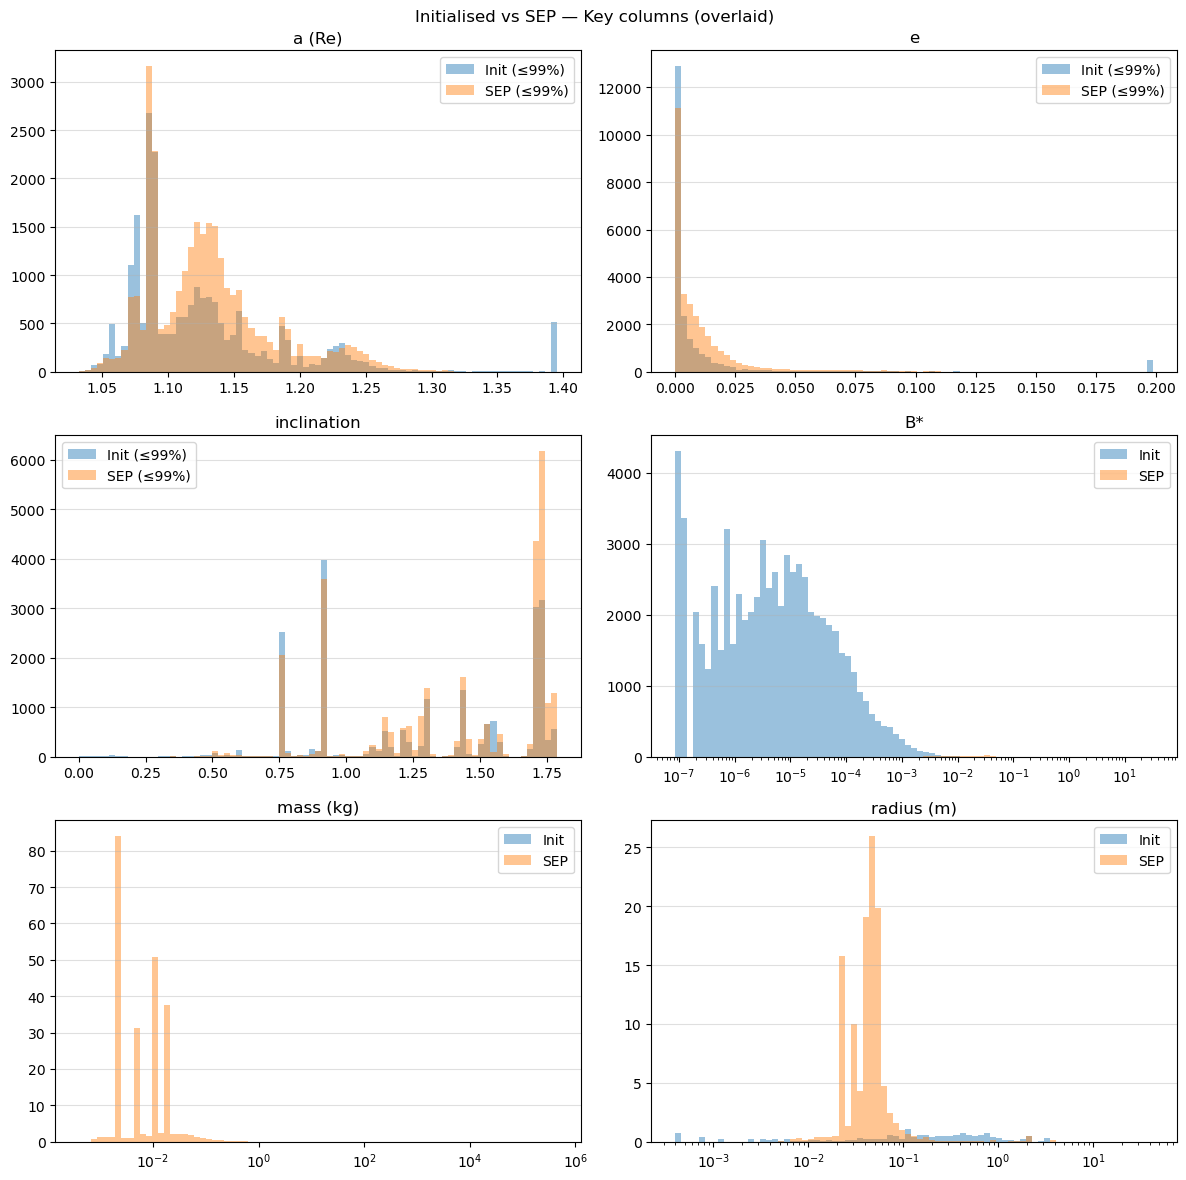

In [12]:
import numpy as np, matplotlib.pyplot as plt
from scipy.io import loadmat

def load_mat(path, keys):
    md = loadmat(path, squeeze_me=True, struct_as_record=False)
    for k in keys:
        if k in md:
            arr = np.asarray(md[k])
            return arr if arr.ndim==2 else arr.reshape(-1, arr.shape[-1])
    raise KeyError(f"None of {keys} in {path}")
INIT_PATH = '/Users/indigobrownhall/Code/mocat-VnV-old/supporting_data/mat_sats.mat'
SEP_PATH = '/Users/indigobrownhall/Code/mocat-VnV-old/supporting_data/ref_scen_SEP1_initial_pop.mat'
init = load_mat(INIT_PATH, ['mat_sats'])
sep  = load_mat(SEP_PATH, ['mat_sats_initial_pop'])

# Column map (MATLAB 1-based → Python 0-based)
COL = dict(a=0, e=1, i=2, bstar=6, mass=7, radius=8)

def clean(x): 
    x = x.astype(float).ravel()
    return x[np.isfinite(x)]

def log_hist(ax, x1, x2, label1, label2, nbins=80):
    x1, x2 = x1[x1>0], x2[x2>0]
    pool = np.concatenate([x1, x2])
    lo, hi = max(pool.min(), np.finfo(float).tiny), pool.max()
    edges = np.logspace(np.log10(lo), np.log10(hi), nbins)
    ax.hist(x1, bins=edges, density=True, alpha=0.45, label=label1)
    ax.hist(x2, bins=edges, density=True, alpha=0.45, label=label2)
    ax.set_xscale('log'); ax.grid(True, which='both', axis='y', alpha=0.4)

def lin_hist(ax, x1, x2, pct=99, nbins=80):
    pool = np.concatenate([x1, x2]); cap = np.percentile(pool, pct)
    x1c, x2c = np.clip(x1, None, cap), np.clip(x2, None, cap)
    lo, hi = min(x1c.min(), x2c.min()), max(x1c.max(), x2c.max())
    edges = np.linspace(lo, hi, nbins)
    ax.hist(x1c, bins=edges, alpha=0.45, label=f'Init (≤{pct}%)')
    ax.hist(x2c, bins=edges, alpha=0.45, label=f'SEP (≤{pct}%)')
    ax.grid(True, axis='y', alpha=0.4)

pairs = [
    ('a (Re)',      clean(init[:,COL['a']]),      clean(sep[:,COL['a']]),      False),
    ('e',           clean(init[:,COL['e']]),      clean(sep[:,COL['e']]),      False),
    ('inclination', clean(init[:,COL['i']]),      clean(sep[:,COL['i']]),      False),
    ('B*',          clean(init[:,COL['bstar']]),  clean(sep[:,COL['bstar']]),  True),
    ('mass (kg)',   clean(init[:,COL['mass']]),   clean(sep[:,COL['mass']]),   True),
    ('radius (m)',  clean(init[:,COL['radius']]), clean(sep[:,COL['radius']]), True),
]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, (label, x1, x2, use_log) in zip(axes.ravel(), pairs):
    if use_log:
        log_hist(ax, x1, x2, 'Init', 'SEP')
    else:
        lin_hist(ax, x1, x2, pct=99)
    ax.set_title(label); ax.legend()

plt.suptitle('Initialised vs SEP — Key columns (overlaid)', y=0.98)
plt.tight_layout(); plt.show()

Init mass: n=21946, positive=21917, min=0, median=126, max=4.5e+05
SEP  mass: n=29146,  positive=29146,  min=0.0004,  median=0.0503,  max=2.26e+04


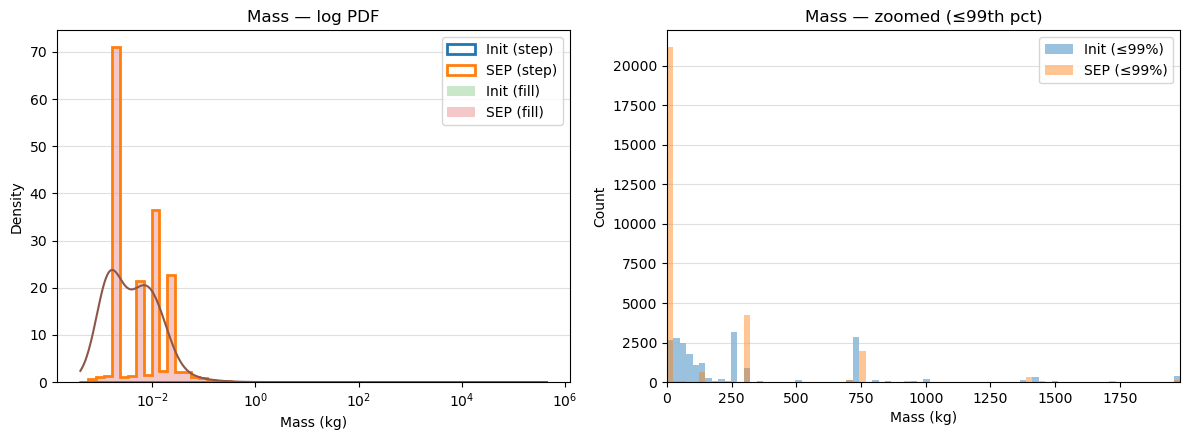

In [13]:
def load_mat_array(path, varnames):
    """
    Load a 2D numeric array from a .mat file.
    Tries scipy.io.loadmat; falls back to h5py for v7.3 files.
    Returns a 2D np.ndarray (rows=objects, cols=features).
    """
    # 1) Try classic MAT
    try:
        from scipy.io import loadmat
        md = loadmat(path, squeeze_me=True, struct_as_record=False)
        for vn in varnames:
            if vn in md:
                arr = np.array(md[vn])
                break
        else:
            raise KeyError(f"None of {varnames} in {path}")
    except NotImplementedError:
        # 2) v7.3 (HDF5) fallback
        import h5py
        with h5py.File(path, "r") as f:
            for vn in varnames:
                if vn in f:
                    arr = np.array(f[vn])
                    break
            else:
                raise KeyError(f"None of {varnames} in {path} (HDF5)")
    # Ensure 2D
    arr = np.atleast_2d(arr)
    # Heuristic: expect ~20–30 columns. If columns < rows and < 5, transpose.
    if arr.shape[1] < 5 and arr.shape[0] >= 9:
        arr = arr.T
    # Final sanity: must have at least 9 columns
    if arr.shape[1] < 9:
        raise ValueError(f"{path} loaded with shape {arr.shape}, expected >= 9 columns.")
    return arr

def clean_pos(x):
    x = np.asarray(x, dtype=float).ravel()
    x = x[np.isfinite(x)]
    pos = x[x > 0]
    return x, pos

def fd_edges(x, max_bins=80):
    """Freedman–Diaconis edges with sensible fallbacks."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return np.linspace(np.min(x), np.max(x), 10)
    IQR = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2 * IQR / (x.size ** (1/3)) if IQR > 0 else (np.max(x) - np.min(x)) / 30
    if not np.isfinite(bw) or bw <= 0:
        return np.linspace(np.min(x), np.max(x), 30)
    nbins = max(10, min(int(np.ceil((np.max(x) - np.min(x)) / bw)), max_bins))
    return np.linspace(np.min(x), np.max(x), nbins + 1)

def log_hist_overlay(ax, x_init, x_sep, label_init="Init", label_sep="SEP", nbins=60):
    x_init = x_init[(x_init > 0) & np.isfinite(x_init)]
    x_sep  = x_sep[(x_sep  > 0) & np.isfinite(x_sep)]
    if x_init.size == 0 and x_sep.size == 0:
        ax.text(0.5, 0.5, 'No positive data', ha='center', va='center')
        return
    pool = np.concatenate([x_init, x_sep]) if x_init.size and x_sep.size else (x_init if x_init.size else x_sep)
    xmin = max(pool.min(), np.finfo(float).tiny)
    xmax = pool.max()
    edges = np.logspace(np.log10(xmin), np.log10(xmax), nbins)

    # Plot outlines so one set can't fully hide the other
    ax.hist(x_init, bins=edges, density=True, histtype='step', linewidth=2, label=f'{label_init} (step)')
    ax.hist(x_sep,  bins=edges, density=True, histtype='step', linewidth=2, label=f'{label_sep} (step)')

    # Light fill (transparent) for readability
    ax.hist(x_init, bins=edges, density=True, alpha=0.25, label=f'{label_init} (fill)')
    ax.hist(x_sep,  bins=edges, density=True, alpha=0.25, label=f'{label_sep} (fill)')

    # Optional KDEs in log space (change of variables)
    if HAS_SCIPY:
        xs = np.logspace(np.log10(xmin), np.log10(xmax), 400)
        if x_init.size > 10:
            kde_i = gaussian_kde(np.log10(x_init))
            pdf_i = kde_i(np.log10(xs)) / (xs * np.log(10))
            ax.plot(xs, pdf_i, linewidth=1.5)
        if x_sep.size > 10:
            kde_s = gaussian_kde(np.log10(x_sep))
            pdf_s = kde_s(np.log10(xs)) / (xs * np.log(10))
            ax.plot(xs, pdf_s, linewidth=1.5)

    ax.set_xscale('log')
    ax.set_ylabel('Density')
    ax.grid(True, which='both', axis='y', alpha=0.4)

def lin_hist_overlay(ax, x_init, x_sep, cap_pct=99, label_init="Init", label_sep="SEP"):
    x_init = x_init[np.isfinite(x_init)]
    x_sep  = x_sep[np.isfinite(x_sep)]
    if x_init.size == 0 and x_sep.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        return
    pool = np.concatenate([x_init, x_sep]) if x_init.size and x_sep.size else (x_init if x_init.size else x_sep)
    cap = np.percentile(pool, cap_pct)
    xi = np.clip(x_init, None, cap)
    xs = np.clip(x_sep,  None, cap)
    edges = fd_edges(np.concatenate([xi, xs]))
    ax.hist(xi, bins=edges, alpha=0.45, label=f'{label_init} (≤{cap_pct}%)')
    ax.hist(xs, bins=edges, alpha=0.45, label=f'{label_sep} (≤{cap_pct}%)')
    ax.set_xlim(edges[0], edges[-1])
    ax.set_ylabel('Count')
    ax.grid(True, axis='y', alpha=0.4)

# ---- Load data ----
init = load_mat_array(INIT_PATH, ['mat_sats','mat_sats_initial_pop'])
sep  = load_mat_array(SEP_PATH,  ['mat_sats_initial_pop','mat_sats'])

# MATLAB 1-based -> Python 0-based
COL_MASS   = 7   # idx_mass = 8 in MATLAB
COL_RADIUS = 8   # idx_radius = 9 in MATLAB

mass_init, mass_init_pos = clean_pos(init[:, COL_MASS])
mass_sep,  mass_sep_pos  = clean_pos(sep[:,  COL_MASS])

# Diagnostics so we know what's being plotted
print(f"Init mass: n={mass_init.size}, positive={mass_init_pos.size}, "
      f"min={np.nanmin(mass_init):.3g}, median={np.nanmedian(mass_init):.3g}, "
      f"max={np.nanmax(mass_init):.3g}")
print(f"SEP  mass: n={mass_sep.size},  positive={mass_sep_pos.size},  "
      f"min={np.nanmin(mass_sep):.3g},  median={np.nanmedian(mass_sep):.3g},  "
      f"max={np.nanmax(mass_sep):.3g}")

# ---- Make the plots just for MASS (log + zoom) ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Panel A: log-PDF
log_hist_overlay(axes[0], mass_init, mass_sep, label_init="Init", label_sep="SEP")
axes[0].set_title('Mass — log PDF')
axes[0].set_xlabel('Mass (kg)')
axes[0].legend(loc='best')

# Panel B: zoomed linear
lin_hist_overlay(axes[1], mass_init, mass_sep, cap_pct=99, label_init="Init", label_sep="SEP")
axes[1].set_title('Mass — zoomed (≤99th pct)')
axes[1].set_xlabel('Mass (kg)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

INIT_pop mass: n=29146, positives=29146, min=0.0004, median=0.0503, p99=1.43e+03, max=2.26e+04


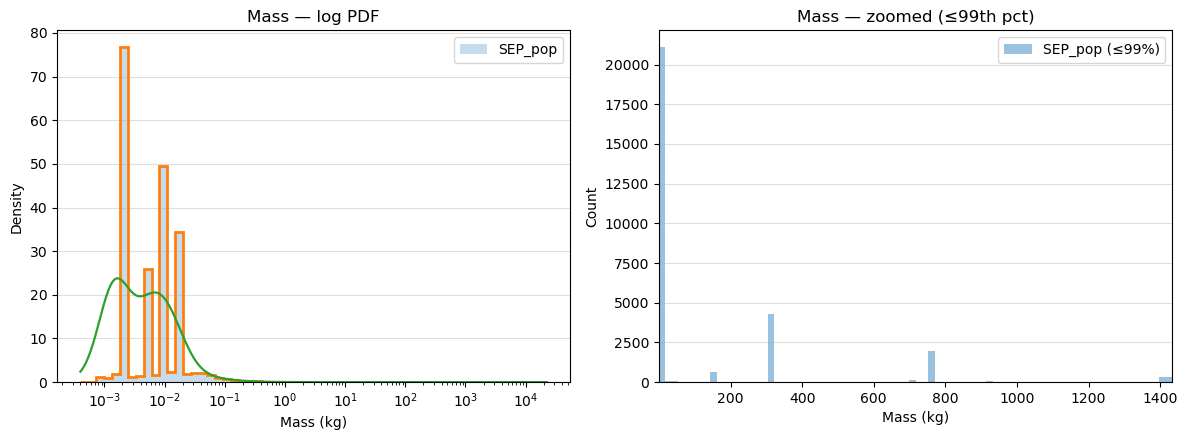

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Optional KDE overlay (fine if missing)
try:
    from scipy.stats import gaussian_kde
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

# --- Helpers ---
def load_mat_array(path, varnames):
    """Return a 2D array (rows=objects, cols=features) for the first var found."""
    try:
        from scipy.io import loadmat
        md = loadmat(path, squeeze_me=True, struct_as_record=False)
        for vn in varnames:
            if vn in md:
                arr = np.array(md[vn])
                break
        else:
            raise KeyError(f"None of {varnames} in {path}")
    except NotImplementedError:
        import h5py
        with h5py.File(path, "r") as f:
            for vn in varnames:
                if vn in f:
                    arr = np.array(f[vn])
                    break
            else:
                raise KeyError(f"None of {varnames} in {path} (HDF5)")
    arr = np.atleast_2d(arr)
    if arr.shape[1] < 5 and arr.shape[0] >= 9:  # orientation fix
        arr = arr.T
    if arr.shape[1] < 9:
        raise ValueError(f"{path} shape {arr.shape}, expected ≥ 9 columns.")
    return arr

def clean(x):
    x = np.asarray(x, float).ravel()
    return x[np.isfinite(x)]

def fd_edges(x, max_bins=80):
    x = clean(x)
    if x.size < 2: return np.linspace(np.min(x), np.max(x), 10)
    IQR = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2*IQR / (x.size ** (1/3)) if IQR > 0 else (np.max(x)-np.min(x))/30
    if not np.isfinite(bw) or bw <= 0:
        return np.linspace(np.min(x), np.max(x), 30)
    nbins = max(10, min(int(np.ceil((np.max(x)-np.min(x))/bw)), max_bins))
    return np.linspace(np.min(x), np.max(x), nbins + 1)

def log_pdf_single(ax, x, label="INIT_pop", nbins=60):
    x = clean(x); x = x[x > 0]
    if x.size == 0:
        ax.text(0.5, 0.5, 'No positive data', ha='center', va='center')
        return
    lo = max(x.min(), np.finfo(float).tiny); hi = x.max()
    edges = np.logspace(np.log10(lo), np.log10(hi), nbins)
    ax.hist(x, bins=edges, density=True, alpha=0.25, label=label)
    ax.hist(x, bins=edges, density=True, histtype='step', linewidth=2)
    if HAS_SCIPY and x.size > 10:
        xs = np.logspace(np.log10(lo), np.log10(hi), 400)
        kde = gaussian_kde(np.log10(x))
        pdf = kde(np.log10(xs)) / (xs * np.log(10))
        ax.plot(xs, pdf, linewidth=1.6)
    ax.set_xscale('log'); ax.set_ylabel('Density'); ax.grid(True, which='both', axis='y', alpha=0.4)
    ax.legend(loc='best')

def linear_zoom_single(ax, x, label="INIT_pop", cap_pct=99):
    x = clean(x)
    if x.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center'); return
    cap = np.percentile(x, cap_pct)
    xz = np.clip(x, None, cap)
    edges = fd_edges(xz)
    ax.hist(xz, bins=edges, alpha=0.45, label=f'{label} (≤{cap_pct}%)')
    ax.set_xlim(edges[0], edges[-1]); ax.set_ylabel('Count'); ax.grid(True, axis='y', alpha=0.4)
    ax.legend(loc='best')

# --- Load INIT_pop and extract MASS (MATLAB col 8 → Python index 7) ---
init = load_mat_array(SEP_PATH, ['mat_sats', 'mat_sats_initial_pop'])
COL_MASS = 7
mass_init = init[:, COL_MASS].astype(float)

# Diagnostics
pos = mass_init[mass_init > 0]
print(f"INIT_pop mass: n={mass_init.size}, positives={pos.size}, "
      f"min={np.nanmin(mass_init):.3g}, median={np.nanmedian(mass_init):.3g}, "
      f"p99={np.nanpercentile(mass_init,99):.3g}, max={np.nanmax(mass_init):.3g}")

# --- Plots (mass only) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

log_pdf_single(axes[0], mass_init, label="SEP_pop")
axes[0].set_title('Mass — log PDF')
axes[0].set_xlabel('Mass (kg)')

linear_zoom_single(axes[1], mass_init, label="SEP_pop", cap_pct=99)
axes[1].set_title('Mass — zoomed (≤99th pct)')
axes[1].set_xlabel('Mass (kg)')

plt.tight_layout()
plt.show()

INIT radius: n=21946, positives=21889, min=0, median=0.95, p99=3.43, max=42.8
SEP radius: n=29146, positives=29146, min=0.005, median=0.0535, p99=3.91, max=6.65


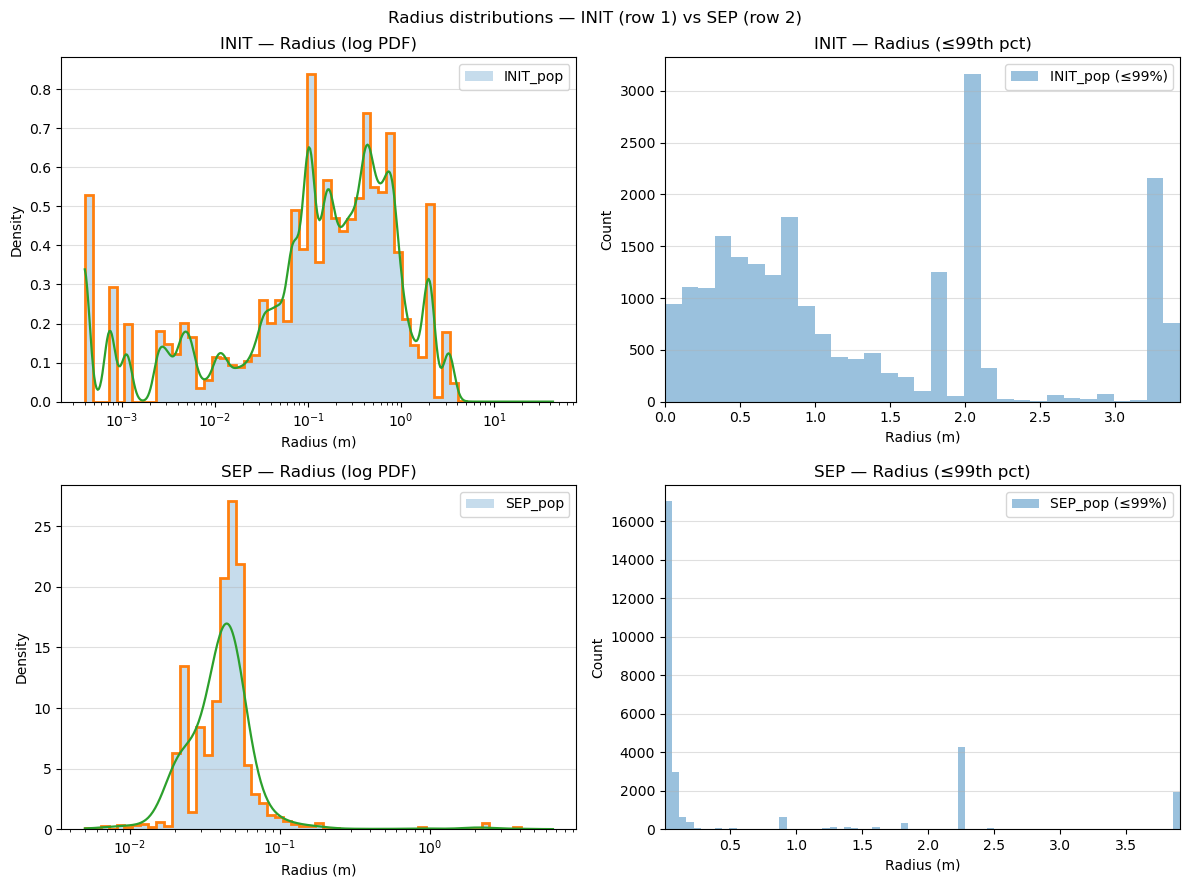

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Optional KDE overlay
try:
    from scipy.stats import gaussian_kde
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

# --- Helpers ---
def load_mat_array(path, varnames):
    """Return a 2D array (rows=objects, cols=features) for the first var found."""
    try:
        from scipy.io import loadmat
        md = loadmat(path, squeeze_me=True, struct_as_record=False)
        for vn in varnames:
            if vn in md:
                arr = np.array(md[vn])
                break
        else:
            raise KeyError(f"None of {varnames} in {path}")
    except NotImplementedError:
        import h5py
        with h5py.File(path, "r") as f:
            for vn in varnames:
                if vn in f:
                    arr = np.array(f[vn])
                    break
            else:
                raise KeyError(f"None of {varnames} in {path} (HDF5)")
    arr = np.atleast_2d(arr)
    # Orientation fix if saved transposed
    if arr.shape[1] < 5 and arr.shape[0] >= 9:
        arr = arr.T
    if arr.shape[1] < 9:
        raise ValueError(f"{path} shape {arr.shape}, expected ≥ 9 columns.")
    return arr

def clean(x):
    x = np.asarray(x, float).ravel()
    return x[np.isfinite(x)]

def fd_edges(x, max_bins=80):
    x = clean(x)
    if x.size < 2:
        return np.linspace(np.min(x), np.max(x), 10)
    IQR = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2*IQR / (x.size ** (1/3)) if IQR > 0 else (np.max(x) - np.min(x))/30
    if not np.isfinite(bw) or bw <= 0:
        return np.linspace(np.min(x), np.max(x), 30)
    nbins = max(10, min(int(np.ceil((np.max(x) - np.min(x))/bw)), max_bins))
    return np.linspace(np.min(x), np.max(x), nbins + 1)

def log_pdf_single(ax, x, label, nbins=60):
    x = clean(x); x = x[x > 0]
    if x.size == 0:
        ax.text(0.5, 0.5, 'No positive data', ha='center', va='center')
        return
    lo = max(x.min(), np.finfo(float).tiny); hi = x.max()
    edges = np.logspace(np.log10(lo), np.log10(hi), nbins)
    ax.hist(x, bins=edges, density=True, alpha=0.25, label=label)
    ax.hist(x, bins=edges, density=True, histtype='step', linewidth=2)
    if HAS_SCIPY and x.size > 10:
        xs = np.logspace(np.log10(lo), np.log10(hi), 400)
        kde = gaussian_kde(np.log10(x))
        pdf = kde(np.log10(xs)) / (xs * np.log(10))
        ax.plot(xs, pdf, linewidth=1.6)
    ax.set_xscale('log'); ax.set_ylabel('Density'); ax.grid(True, which='both', axis='y', alpha=0.4)
    ax.legend(loc='best')

def linear_zoom_single(ax, x, label, cap_pct=99):
    x = clean(x)
    if x.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center'); return
    cap = np.percentile(x, cap_pct)
    xz = np.clip(x, None, cap)
    edges = fd_edges(xz)
    ax.hist(xz, bins=edges, alpha=0.45, label=f'{label} (≤{cap_pct}%)')
    ax.set_xlim(edges[0], edges[-1]); ax.set_ylabel('Count'); ax.grid(True, axis='y', alpha=0.4)
    ax.legend(loc='best')

# --- Load both files and extract RADIUS (MATLAB col 9 → Python index 8) ---
COL_RADIUS = 8

init_arr = load_mat_array(INIT_PATH, ['mat_sats', 'mat_sats_initial_pop'])
sep_arr  = load_mat_array(SEP_PATH,  ['mat_sats_initial_pop', 'mat_sats'])

rad_init = init_arr[:, COL_RADIUS].astype(float)
rad_sep  = sep_arr[:,  COL_RADIUS].astype(float)

# Diagnostics (optional)
for name, x in [('INIT radius', rad_init), ('SEP radius', rad_sep)]:
    x_clean = clean(x)
    pos = x_clean[x_clean > 0]
    print(f"{name}: n={x_clean.size}, positives={pos.size}, "
          f"min={np.min(x_clean):.3g}, median={np.median(x_clean):.3g}, "
          f"p99={np.percentile(x_clean,99):.3g}, max={np.max(x_clean):.3g}")

# --- Figure: 2 rows (INIT, SEP) × 2 cols (log-PDF, zoomed) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=False)

# Row 1 — INIT
log_pdf_single(axes[0, 0], rad_init, label="INIT_pop")
axes[0, 0].set_title('INIT — Radius (log PDF)')
axes[0, 0].set_xlabel('Radius (m)')

linear_zoom_single(axes[0, 1], rad_init, label="INIT_pop", cap_pct=99)
axes[0, 1].set_title('INIT — Radius (≤99th pct)')
axes[0, 1].set_xlabel('Radius (m)')

# Row 2 — SEP
log_pdf_single(axes[1, 0], rad_sep, label="SEP_pop")
axes[1, 0].set_title('SEP — Radius (log PDF)')
axes[1, 0].set_xlabel('Radius (m)')

linear_zoom_single(axes[1, 1], rad_sep, label="SEP_pop", cap_pct=99)
axes[1, 1].set_title('SEP — Radius (≤99th pct)')
axes[1, 1].set_xlabel('Radius (m)')

plt.suptitle('Radius distributions — INIT (row 1) vs SEP (row 2)', y=0.98)
plt.tight_layout()
plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_90048/3169952853.py:100: RuntimeWarning: divide by zero encountered in divide
  bstar_init = np.where(mass_init > 0, 2.2 * (area_init * 1e6) / mass_init, np.nan)
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_90048/3169952853.py:100: RuntimeWarning: invalid value encountered in divide
  bstar_init = np.where(mass_init > 0, 2.2 * (area_init * 1e6) / mass_init, np.nan)


INIT B*: n=21917, positives=21868, min=0, median=6.35e+04, p99=4.87e+05, max=8.89e+07
SEP B*: n=29146, positives=29146, min=1.52e+03, median=3.71e+05, p99=2.15e+06, max=1.02e+08


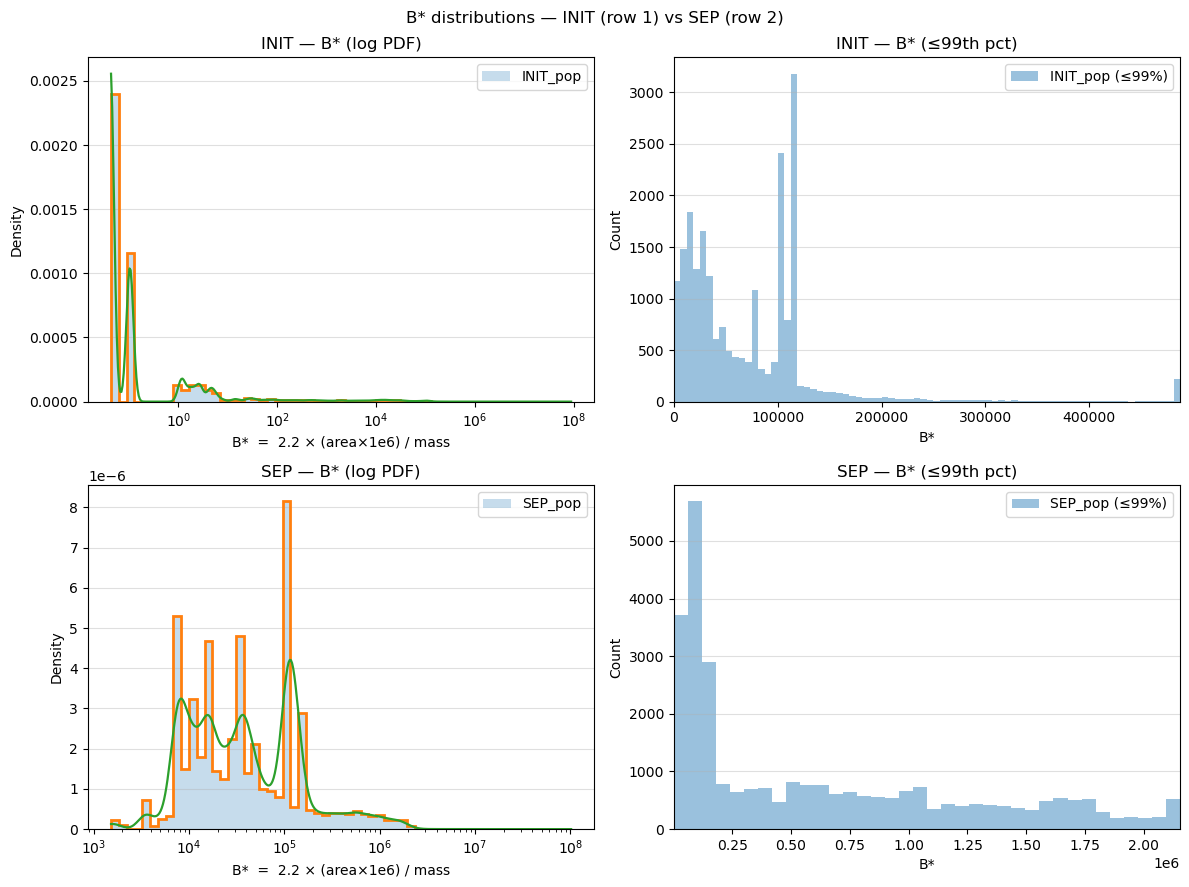

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Optional KDE overlay
try:
    from scipy.stats import gaussian_kde
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False


# --- Loader (classic .mat and v7.3 HDF5) ---
def load_mat_array(path, varnames):
    """Return a 2D array (rows=objects, cols=features) for the first var found."""
    try:
        from scipy.io import loadmat
        md = loadmat(path, squeeze_me=True, struct_as_record=False)
        for vn in varnames:
            if vn in md:
                arr = np.array(md[vn])
                break
        else:
            raise KeyError(f"None of {varnames} in {path}")
    except NotImplementedError:
        import h5py
        with h5py.File(path, "r") as f:
            for vn in varnames:
                if vn in f:
                    arr = np.array(f[vn])
                    break
            else:
                raise KeyError(f"None of {varnames} in {path} (HDF5)")
    arr = np.atleast_2d(arr)
    # Orientation fix if saved transposed
    if arr.shape[1] < 5 and arr.shape[0] >= 9:
        arr = arr.T
    if arr.shape[1] < 9:
        raise ValueError(f"{path} shape {arr.shape}, expected ≥ 9 columns.")
    return arr

def clean(x):
    x = np.asarray(x, float).ravel()
    return x[np.isfinite(x)]

def fd_edges(x, max_bins=80):
    x = clean(x)
    if x.size < 2:
        return np.linspace(np.min(x), np.max(x), 10)
    IQR = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2*IQR / (x.size ** (1/3)) if IQR > 0 else (np.max(x)-np.min(x))/30
    if not np.isfinite(bw) or bw <= 0:
        return np.linspace(np.min(x), np.max(x), 30)
    nbins = max(10, min(int(np.ceil((np.max(x)-np.min(x))/bw)), max_bins))
    return np.linspace(np.min(x), np.max(x), nbins + 1)

def log_pdf_single(ax, x, label, nbins=60):
    x = clean(x); x = x[x > 0]
    if x.size == 0:
        ax.text(0.5, 0.5, 'No positive data', ha='center', va='center'); return
    lo = max(x.min(), np.finfo(float).tiny); hi = x.max()
    edges = np.logspace(np.log10(lo), np.log10(hi), nbins)
    ax.hist(x, bins=edges, density=True, alpha=0.25, label=label)
    ax.hist(x, bins=edges, density=True, histtype='step', linewidth=2)
    if HAS_SCIPY and x.size > 10:
        xs = np.logspace(np.log10(lo), np.log10(hi), 400)
        kde = gaussian_kde(np.log10(x))
        pdf = kde(np.log10(xs)) / (xs * np.log(10))
        ax.plot(xs, pdf, linewidth=1.6)
    ax.set_xscale('log'); ax.set_ylabel('Density'); ax.grid(True, which='both', axis='y', alpha=0.4)
    ax.legend(loc='best')

def linear_zoom_single(ax, x, label, cap_pct=99):
    x = clean(x)
    if x.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center'); return
    cap = np.percentile(x, cap_pct)
    xz = np.clip(x, None, cap)
    edges = fd_edges(xz)
    ax.hist(xz, bins=edges, alpha=0.45, label=f'{label} (≤{cap_pct}%)')
    ax.set_xlim(edges[0], edges[-1]); ax.set_ylabel('Count'); ax.grid(True, axis='y', alpha=0.4)
    ax.legend(loc='best')

# --- Load both files ---
COL_MASS   = 7  # MATLAB col 8 → Python index 7
COL_RADIUS = 8  # MATLAB col 9 → Python index 8

arr_init = load_mat_array(INIT_PATH, ['mat_sats', 'mat_sats_initial_pop'])
arr_sep  = load_mat_array(SEP_PATH,  ['mat_sats_initial_pop', 'mat_sats'])

mass_init = arr_init[:, COL_MASS].astype(float)
mass_sep  = arr_sep[:,  COL_MASS].astype(float)
rad_init  = arr_init[:, COL_RADIUS].astype(float)
rad_sep   = arr_sep[:,  COL_RADIUS].astype(float)

# --- Compute area from radius & B* ---
area_init = np.pi * np.square(rad_init)
area_sep  = np.pi * np.square(rad_sep)

# Avoid divide-by-zero; set invalid to NaN then clean in plotting
bstar_init = np.where(mass_init > 0, 2.2 * (area_init * 1e6) / mass_init, np.nan)
bstar_sep  = np.where(mass_sep  > 0, 2.2 * (area_sep  * 1e6) / mass_sep,  np.nan)

# Quick diagnostics
for name, x in [('INIT B*', bstar_init), ('SEP B*', bstar_sep)]:
    xc = clean(x); pos = xc[xc > 0]
    print(f"{name}: n={xc.size}, positives={pos.size}, "
          f"min={np.min(xc):.3g}, median={np.median(xc):.3g}, "
          f"p99={np.percentile(xc,99):.3g}, max={np.max(xc):.3g}")

# --- Figure: 2 rows (INIT, SEP) × 2 cols (log-PDF, zoomed linear) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=False)

# Row 1 — INIT
log_pdf_single(axes[0, 0], bstar_init, label="INIT_pop")
axes[0, 0].set_title('INIT — B* (log PDF)')
axes[0, 0].set_xlabel('B*  =  2.2 × (area×1e6) / mass')

linear_zoom_single(axes[0, 1], bstar_init, label="INIT_pop", cap_pct=99)
axes[0, 1].set_title('INIT — B* (≤99th pct)')
axes[0, 1].set_xlabel('B*')

# Row 2 — SEP
log_pdf_single(axes[1, 0], bstar_sep, label="SEP_pop")
axes[1, 0].set_title('SEP — B* (log PDF)')
axes[1, 0].set_xlabel('B*  =  2.2 × (area×1e6) / mass')

linear_zoom_single(axes[1, 1], bstar_sep, label="SEP_pop", cap_pct=99)
axes[1, 1].set_title('SEP — B* (≤99th pct)')
axes[1, 1].set_xlabel('B*')

plt.suptitle('B* distributions — INIT (row 1) vs SEP (row 2)', y=0.98)
plt.tight_layout()
plt.show()